###  Q-learning and Reinforcement learning, FrozenLake, randomized grid

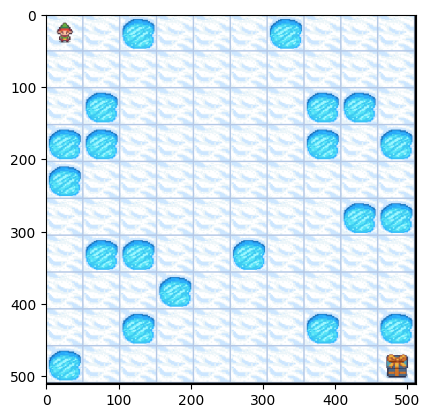

In [2]:
# import necessary python libraries
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

# Here, I defined a custom map, S => start, G => goal, F => normal ice tile, H => hole 
custom_map = generate_random_map(size=10)

# create the FrozenLake environment, DISABLE SLIPPERY
env = gym.make("FrozenLake-v1", is_slippery=False, render_mode="rgb_array", desc=custom_map)

# it would be logical to have width + height
# we have to double-check that we get the correct values in this order 
grid_height, grid_width  = env.unwrapped.desc.shape

# documentation for this environment:
# https://gymnasium.farama.org/environments/toy_text/frozen_lake/

env.reset()
plt.imshow(env.render())

In [3]:
# let's inspect the environment
print("Observation space:")
print(env.observation_space)

print("\nAction space:")
print(env.action_space)

# in other words observation space => 4 x 4 grid => 16 cells
# action space => 4 different movements are possible => up, right, down, left

Observation space:
Discrete(100)

Action space:
Discrete(4)


In [4]:
# this is the table that is used in Q-learning
Q_table = np.zeros([env.observation_space.n, env.action_space.n])
Q_table.shape

(100, 4)

In [8]:
# created the function that update the Q-Learning
def calculate_value(Q, state, action, reward, next_state, alpha, gamma):
    Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])
    return Q

In [9]:
def summarize_best_values(q_table, grid_width, grid_height):
    # get a list of highest values for each cell
    best_values = np.max(q_table, axis=1)

    # reshape into matrix that is the same shape as the environment
    return best_values.reshape(grid_height, grid_width)

In [16]:
# helper variables for our Q-learning training algorithm

# learning rate (alpha) => usually good idea to start with 0.5, if the total rewards 
total_episodes = 20000

# how many steps our agent tries within one episode
# until we give up with that episode
max_steps = 50

learning_rate = 0.1

# this is how much the AI values long-term rewards over short-term rewards
# gamma of 0.9 is very typical in basic Q-learning 
gamma = 0.9

# epsilon does helps to
# determine how much our agent relies on current knowledge
# and how much the agent does wild guessing while training

# in the beginning of training 
# lots of guessing (high epsilon)
# but towards the end of training 
# then resulted to less guessing and more trusting previous knowledge (smaller epsilon)
# Simply because there is need for guessing in the beginning 
# whichhelps to start the learning
# know the optimal first steps in our current Q-table
epsilon = 0.9

# upper bound of our epsilon
max_epsilon = 0.9

# this is the lower bound, and our code is not going to decay the epsilon below this
min_epsilon = 0.01
decay_rate = 0.0005

### Now, training the agent with a for-loop (based on episodes)

In [17]:
# "play" the game for the amount episodes defined
for episode in range(total_episodes):
    # Gymnasium environments usually have to be reset before training
    # this get the initial state + info-variable (info is not required usually)
    state, info = env.reset()

    # in the beginning of the game, the game is not over
    # the game is done either by falling into a hole or finding the goal
    done = False

    # in the beginning of the game, our total_rewards are 0
    total_rewards = 0

    
    # (this example: give up after 50 steps -> probably not optimal route)
    for step in range(max_steps):
        # this is what we need to do:

    
        # here, using the epsilon to decide whether we should trust previous knowledge
        # or take a wild guess
        # epsilon -> should we EXPLOIT our current knowledge or explore (wild guess)
        if np.random.uniform(0, 1) > epsilon:
            # use exploitation in this case => use best known action for this cell!
            action = np.argmax(Q_table[state, :])
        else:
            # the random action
            action = env.action_space.sample()


        # and unpack the results into: observation, reward, done
        observation, reward, done, truncated, info = env.step(action)

        
        # this will eventually guide the agent to choose the shortest path with least moves
        reward = reward - 0.01

       
        # if agent drops into a hole, we just adjust the reward accordingly, and stop this episode
        if done and reward <= 0:
            reward = -1
            Q_table = calculate_value(Q_table, state, action, reward, observation, learning_rate, gamma)
            total_rewards = total_rewards + reward
            break
            
        # updating the Q-table with the values we have right now
        # NOTE: this phase will be skipped if the agent dropped down a hole in previous section
        Q_table = calculate_value(Q_table, state, action, reward, observation, learning_rate, gamma)

        # ave current state and update rewards
        state = observation
        total_rewards = total_rewards + reward

        # this checks for either lost or won the game
        if done:
            print(f"Steps taken: {step}")

            #     print(f"Current Q-table - Episode: {episode}")
            #     print(summarize_best_values(Q_table, grid_width, grid_height))
            #     print()

            break

    # instead of linear decay, we have an expontential curve
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

    # only print the result if our rewards are positive
    if total_rewards >= 0:
        print(f"Episode {episode} done with total rewards: {total_rewards}, epsilon: {epsilon}")

Steps taken: 29
Episode 363 done with total rewards: 0.7, epsilon: 0.7522762383200968
Steps taken: 43
Episode 466 done with total rewards: 0.5599999999999998, epsilon: 0.7150166804366395
Steps taken: 34
Episode 583 done with total rewards: 0.6499999999999999, epsilon: 0.6749563921066437
Steps taken: 22
Episode 600 done with total rewards: 0.7699999999999999, epsilon: 0.6693282164067289
Steps taken: 29
Episode 714 done with total rewards: 0.7, epsilon: 0.6327975229838039
Steps taken: 25
Episode 734 done with total rewards: 0.74, epsilon: 0.6266005840895086
Steps taken: 43
Episode 811 done with total rewards: 0.5599999999999998, epsilon: 0.6033126311720152
Steps taken: 34
Episode 831 done with total rewards: 0.6499999999999999, epsilon: 0.5974090718531351
Steps taken: 30
Episode 881 done with total rewards: 0.69, epsilon: 0.5829058901937257
Steps taken: 30
Episode 912 done with total rewards: 0.69, epsilon: 0.5740943150177086
Steps taken: 31
Episode 913 done with total rewards: 0.6799999

### Meanwhile, when I reduced the learning_rate from 0.5 (middle fairly updates) to 0.1 (low mild updates), the total rewards values increase to 0.82 : The reason being the environment is in large world game

#### I noticed from the training process there was decrease in the epsilon value in the episodes but not as rapid perhaps because of the numerous grids. Which I think the agent was able to learn pretty well within the episodes which resulted to reducing the random guessing value of the epsilon almost to 0.0100 from 0.9. The Q-table also has negative values which punishes the agent for taking steps that do not have an impact in the long term goal. So, I will say the learning_rate = 0.5 for this large world not quite updates to value properly as total_rewards increased to 0.79 instead of 1.0 as the epsilon reduced from 0.9 to 0.0100


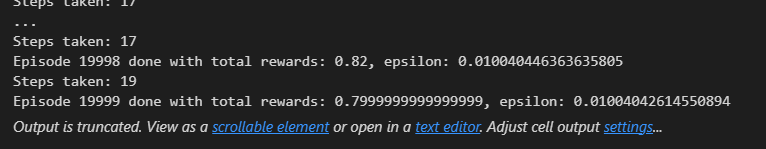

#### When learning_rate = 0.5

In [18]:
# the raw Q-table is a bit hard to read for us, since for each cell we have a different value 
# for each action
Q_table

# each list in each row is one cell in the grid
# each value in a list is the quality of action based on:
# 0: Move left, 1: Move down, 2: Move right, 3: Move up




array([[ 0.06360315,  0.08178128,  0.08178128,  0.06360315],
       [ 0.06360315,  0.1019792 , -1.        ,  0.08178128],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.99753497,  0.1493481 ,  0.06273609,  0.11270723],
       [ 0.0940289 ,  0.14741112,  0.01800736,  0.03700773],
       [-0.0104686 ,  0.09864731, -0.90152291, -0.03287289],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.90152291, -0.03510313, -0.03563749, -0.03614648],
       [-0.03484452, -0.03450129, -0.035398  , -0.03405969],
       [-0.03445295, -0.03409825, -0.03420561, -0.03297601],
       [ 0.08178128,  0.06360315,  0.1019792 ,  0.06360315],
       [ 0.08178128, -1.        ,  0.12442133,  0.08178128],
       [ 0.1019792 ,  0.14935704,  0.14935704, -1.        ],
       [ 0.1244213 ,  0.17706338,  0.17705932,  0.12437571],
       [ 0.14601377,  0.20784806,  0.14304822,  0.09011058],
       [ 0.17620441,  0.08498569, -0.00368703, -0.01099561],
       [ 0.05413349,  0.

In [19]:
# a helper function is needed for this!
# 0: Move left, 1: Move down, 2: Move right, 3: Move up
results = summarize_best_values(Q_table, grid_width, grid_height)

df = pd.DataFrame(results)
df

# compare the summarized best values grid to the actual grid below

,0,1,2,3,4,5,6,7,8,9
0,0.081781,0.101979,0.000000,0.149348,0.147411,0.098647,0.000000,-0.035103,-0.034060,-0.032976
1,0.101979,0.124421,0.149357,0.177063,0.207848,0.176204,0.054133,-0.036905,-0.034202,-0.032726
2,0.081781,0.000000,0.177063,0.207848,0.242054,0.205306,0.211379,0.000000,0.000000,-0.030241
3,0.000000,0.000000,0.207848,0.242054,0.280059,0.241640,0.346170,0.000000,-0.018517,0.000000
4,0.000000,0.207848,0.242054,0.280059,0.322288,0.368618,0.421321,0.256145,-0.019801,-0.018156
5,0.203631,0.242054,0.280059,0.322288,0.369209,0.421336,0.479271,0.388551,0.000000,0.000000
6,0.035419,0.000000,0.000000,0.369209,0.421344,0.000000,0.543634,0.552573,0.682330,0.144707
7,-0.024239,-0.021283,-0.020576,0.000000,0.479271,0.543634,0.615149,0.694610,0.782900,0.619714
8,-0.020935,-0.018209,0.000000,0.479271,0.543634,0.615149,0.694610,0.000000,0.881000,0.000000
9,0.000000,-0.014774,0.052914,0.495787,0.615149,0.694610,0.782900,0.881000,0.990000,0.000000


### Now playing the training game (Agent)

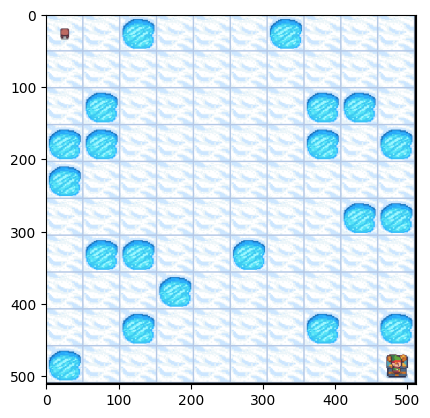

Episode: 5 done with total_rewards: 1.0


In [20]:
# let's use now the Q-table (agent) we have for this environment
# => play the game based on the Q-table but only using exploitation

env.reset()
clear_output(wait=True)
plt.imshow(env.render())
plt.show()

# for-loop => allow the agent to play this 5 times in a row (5 episodes)
for episode in range(5):
    state, info = env.reset()
    done = False
    total_rewards = 0

    # play for the max number of steps
    for step in range(max_steps):
        # take the best action for this situation from the Q-table
        # basically based on the current cell => choose the best action we have calculated
        # in the Q-table during training

        # an idea for the exercise project:
        # => if multiple identical high values => choose a random path
        action = np.argmax(Q_table[state, :])

        # unpack the results
        observation, reward, done, truncated, info = env.step(action)

        # update total rewards
        total_rewards = total_rewards + reward

        # update the visual frame
        clear_output(wait=True)
        plt.imshow(env.render())
        plt.show()

        # if we are game over either by hole or goal => break the loop
        if done:
            print(f"Episode: {episode + 1} done with total_rewards: {total_rewards}")
            time.sleep(2)
            break

        # save new state as old state, continue with next step
        state = observation
        time.sleep(0.3)

### Each value in a list is the quality of action based on and as it increases so the agent learnt to follow the increased value pattern that get it to the reward (G)

### Starts from a low value.

### Movement: the agent moves after the increased value pattern.

### The 'Agent' essentially learnt to observe and making optimal decisions-moving (performed actions) in such ways that its beneficial towards getting to the rewards and not making non-beneficial moves. That could lead to being penalized.

### That finally reaches 0.0000 (Goal).